# 분류(Classfication) - 다중분류(Multi-Class Classification) 문제
- 이미지는 28 X 28
- Gray scale
- label은 0~9까지의 정수

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np

# device 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Dataset 생성

In [2]:
#1. trainset, testset 생성

root_path = r"C:\classes\blog\deeplearning\datasets"
trainset = datasets.FashionMNIST(
    root=root_path,
    train=True,
    download=True,
    transform=transforms.ToTensor() # 이미지 데이터를 tensor로 변환
)
testset = datasets.FashionMNIST(
    root=root_path,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

#2. validation set을 trainset으로부터 생성
trainset, validset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(testset), len(validset)

(50000, 10000, 10000)

In [3]:
#3. 이미지 class 및 label 확인
testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

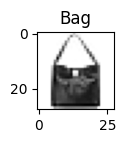

In [4]:
#4. 입력 이미지 확인
idx = 700
x, y = testset[idx] # x가 이미지, y가 라벨링된 class # testset, trainset은 이미지와 class의 레이블을 tuple형태로 반환
plt.figure(figsize=(1, 1))
plt.imshow(x.squeeze(), cmap="Greys") #.squeeze : 이미지 차원 중 크기가 1인차원을 제거하여 2차원 이미지를 만듬.
plt.title(f"{testset.classes[y]}")
plt.show()

In [5]:
# 5. DataLoader 생성
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
valid_loader = DataLoader(validset, batch_size=128)
test_loader = DataLoader(testset, batch_size=128)

# 2. 모델 정의

In [6]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
#1. 모델 정의
class FashionMNISTModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(784, 1024) #위는 0번행 샘플의 이미지 shape을 확인한 것. featrue개수는 1 * 28 * 28
        self.lr2 = nn.Linear(1024, 512)
        self.lr3 = nn.Linear(512, 256)
        self.lr4 = nn.Linear(256, 128)
        self.lr5 = nn.Linear(128, 64)
        # output layer 함수
        self.lr6 = nn.Linear(64, 10)
        # activation 함수
        self.relu = nn.ReLU()

    def forward(self, X):
        out = nn.Flatten()(X) # batch축은 유지하고 그 이후 축들을 flatten 시킨다.
        # hidden layer 계산
        out = self.relu(self.lr1(out))
        out = self.relu(self.lr2(out))
        out = self.relu(self.lr3(out))
        out = self.relu(self.lr4(out))
        out = self.relu(self.lr5(out))
        # output layer
        out = self.lr6(out)
        return out

In [8]:
#2. 모델 객체 저장
f_model = FashionMNISTModel()
print(f_model)

FashionMNISTModel(
  (lr1): Linear(in_features=784, out_features=1024, bias=True)
  (lr2): Linear(in_features=1024, out_features=512, bias=True)
  (lr3): Linear(in_features=512, out_features=256, bias=True)
  (lr4): Linear(in_features=256, out_features=128, bias=True)
  (lr5): Linear(in_features=128, out_features=64, bias=True)
  (lr6): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


# 모델 추론

In [9]:
#1. dummy data를 이용해서 추론(model에 입력)
with torch.no_grad():
    sample = torch.ones((2, 1, 28, 28), dtype=torch.float32) # 예시, 앞의 2는 batch 크기를 나타냄. 즉, 이미지 2개
    y_hat = f_model(sample)
    print(y_hat.shape)

y_hat[0] # 2개의 sample(=batch 크기가 2), 10개의 클래스에 대한 예측

torch.Size([2, 10])


tensor([ 4.0004e-05, -6.8782e-02,  1.3773e-01,  6.8695e-02, -3.9682e-02,
         2.0440e-03, -1.0222e-01, -5.9480e-02,  1.2302e-01, -3.1348e-02])

In [10]:
# 2. class 별 정답 여부값.
i = y_hat[0].argmax(dim=-1) # dim=-1 마지막 차원에 대해서, 최대 확률값을 찾음.
i, testset.classes[i.item()] # i.item은 class의 label 출력, .classes는 class name반환

(tensor(2), 'Pullover')

In [11]:
#3. 정확도
y = torch.tensor([1, 6])
pred = y_hat.argmax(dim=-1)
proba = nn.Softmax(dim=-1)(y_hat)

# 학습 + 검증

In [12]:
# 1. 학습률, epoch, loss, optimizer 정의
lr = 0.001 #학습률
epochs = 10
m_model = FashionMNISTModel().to(device) #모델을 device로 이동
loss_fn = nn.CrossEntropyLoss() # 다중분류의 경우, 손실함수는 CrossEntropy Loss를 주로 사용
# 모델을 추정할 때, Softmax를 통과하면 안됨 -> Softmax를 통과하면 one hot encoding처리가 되는데 이미 처리되어있기 때문.
optimizer = torch.optim.Adam(m_model.parameters(), lr=lr)

In [13]:
#2. 학습
import time

train_loss_list = []
val_loss_list = []
val_acc_list = []

s = time.time()

for epoch in range(epochs):
    m_model.train()
    train_loss = 0.0
    for X_train, y_train in train_loader:
        # 1개 step 학습
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred_train = m_model(X_train)
        loss = loss_fn(pred_train, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    # 1개 epoch 학습 완료. step별로 누적된 train_loss의 평균값을 계산
    train_loss = train_loss / len(train_loader) # losss / 데이터 개수
    train_loss_list.append(train_loss)

###############################################################################
#3. 평가
    m_model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    with torch.no_grad():
        for X_valid, y_valid in valid_loader:
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            pred_valid = m_model(X_valid)
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()
            pred_class = pred_valid.argmax(dim=-1)
            valid_acc = valid_acc + torch.sum(pred_class == y_valid).item()
        # epoch 검증 종료
        valid_loss = valid_loss / len(valid_loader)
        valid_acc = valid_acc / len(valid_loader.dataset) #.dataset은 dataset을 반환
        val_loss_list.append(valid_loss)
        val_acc_list.append(valid_acc)
        print(f"[{epoch+1}/{epochs}] train loss: {train_loss}, valid loss: {valid_loss}, valid_acc: {valid_acc}")

e = time.time()
print(f"학습에 걸린시간: {e-s}초")


[1/10] train loss: 0.6807259947825701, valid loss: 0.43490855641002896, valid_acc: 0.8388
[2/10] train loss: 0.4165897805339251, valid loss: 0.3657770484120031, valid_acc: 0.8632
[3/10] train loss: 0.3586959727299519, valid loss: 0.3425319630982755, valid_acc: 0.8733
[4/10] train loss: 0.3343916634718577, valid loss: 0.35019185346893117, valid_acc: 0.8713
[5/10] train loss: 0.30765015811492236, valid loss: 0.3317758211795288, valid_acc: 0.8738
[6/10] train loss: 0.29439248801806034, valid loss: 0.3273496649499181, valid_acc: 0.8776
[7/10] train loss: 0.2768263478500721, valid loss: 0.32338404509274266, valid_acc: 0.8839
[8/10] train loss: 0.264373428775714, valid loss: 0.3116591458173492, valid_acc: 0.8856
[9/10] train loss: 0.2520552082894704, valid loss: 0.29133845049935053, valid_acc: 0.8915
[10/10] train loss: 0.24071667538239405, valid loss: 0.31887511112078837, valid_acc: 0.8865
학습에 걸린시간: 161.43755722045898초


# 시각화

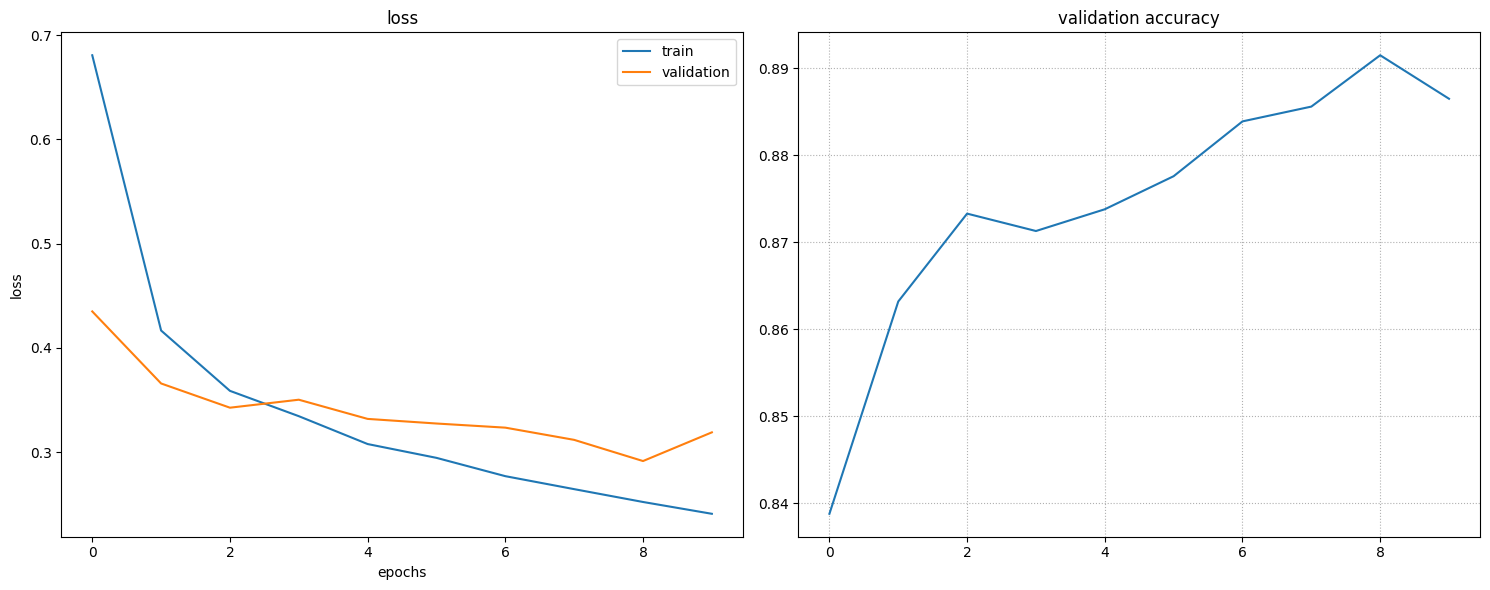

In [15]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_list, label="train")
plt.plot(range(epochs), val_loss_list, label="validation")
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_acc_list)
plt.title('validation accuracy')
plt.grid(True, linestyle=":")

plt.tight_layout()
plt.show()

# 제일 성능 좋은 모델?

In [22]:
best_model = np.argmin(val_loss_list)
best_model

8

In [26]:
val_loss_list[8]

0.29133845049935053

# 모델 저장
- 학습하는 도중 성능이 개선될때마다 저장
- 조기종료(Early Stopping) 로직을 같이 처리
- 기존의 모델을 처음 부터 끝까지 작성 해보자

In [27]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import time

# device 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
#1. 학습률, epoch, model, loss, optimizer 객채 생성

lr = 0.001
epochs = 100
es_model = FashionMNISTModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(es_model.parameters(), lr=lr)

#####################################################################################
#####################################################################################

#2. 조기종료 / 모델 저장 변수 추가.

best_score = torch.inf #초기값은 가장 큰수(무한)으로 지정.
#                      # 초기에 어떤 loss가 나오더라도 초기 best_score보다 작기 때문에 갱신에 용이
#                      # best_score > valid_loss : valid loss의 성능이 더 좋으면 best_score = valid_loss
save_path = "saved_models/fashion_mnist_model.pth"
patience = 5 # 조기 종료시 성능개선이 되는지 기다릴 epoch수
trigger_count = 0 # 성능개선 되는지를 몇번째 기다리는지 저장할 변수
#                 # if patience == trigger_count -> 조기 종료


######################################################################################
######################################################################################

#3. 학습

train_loss_list = []
valid_loss_list = []
valid_acc_list = []

s = time.time()
for epoch in range(epochs):
    es_model.train()
    train_loss = 0.0
    for X_train, y_train in train_loader: 
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred_train = es_model(X_train)
        loss = loss_fn(pred_train, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = train_loss + loss.item()
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
        
    ####################################################################################################################
    ####################################################################################################################

    es_model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    with torch.no_grad():
        for X_valid, y_valid in valid_loader:
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            pred_valid = es_model(X_valid)
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()
            pred_class = pred_valid.argmax(dim=-1)
            valid_acc = valid_acc + torch.sum(pred_class == y_valid).item()
        valid_loss = valid_loss / len(valid_loader)
        valid_acc = valid_acc /  len(valid_loader.dataset) # DataLoader.dataset: Dataset을 반환.
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        print(f"[{epoch+1}/{epochs}] train loss: {train_loss}, valid loss: {valid_loss}, valid_acc: {valid_acc}")

        ####################################################################################################################
        ####################################################################################################################
        
        # 4. 저장 + 조기종료
        if valid_loss < best_score:                 #1) 성능이 개선된 경우
            print(f">>>>> 모델저장: {epoch+1} epoch - best valid loss: {best_score:.5f}, 현재 valid_loss: {valid_loss:.5f}")
            best_score = valid_loss                 #2) best 값을 현 epoch의 valid_loss로 변경.
            torch.save(es_model, save_path)
            trigger_count = 0                       #3) 조기종료 trigger_count=0 으로 초기화
        else:                                       #4) 성능 개선이 안됨 -> 조기 종료 처리
            trigger_count += 1                      #5) trigger_count 를 1 증가.
            if patience == trigger_count:           #6) 지정한 횟수만큼 대기
                print(f"<<<<<< {epoch+1} epoch에서 조기종료. best validation loss: {best_score} 에서 개선안됨.>>>>>>>>")
                break # epochs 의 for in 문 break.


e = time.time()
print(f"학습에 걸린시간: {e-s}초")


[1/100] train loss: 0.6829289600635187, valid loss: 0.4083535055853898, valid_acc: 0.849
>>>>> 모델저장: 1 epoch - best valid loss: inf, 현재 valid_loss: 0.40835
[2/100] train loss: 0.4092554427110232, valid loss: 0.39076067908089374, valid_acc: 0.8596
>>>>> 모델저장: 2 epoch - best valid loss: 0.40835, 현재 valid_loss: 0.39076
[3/100] train loss: 0.356345348747877, valid loss: 0.3466212060538274, valid_acc: 0.87
>>>>> 모델저장: 3 epoch - best valid loss: 0.39076, 현재 valid_loss: 0.34662
[4/100] train loss: 0.3286732636201076, valid loss: 0.3352717147503473, valid_acc: 0.8736
>>>>> 모델저장: 4 epoch - best valid loss: 0.34662, 현재 valid_loss: 0.33527
[5/100] train loss: 0.308533277343481, valid loss: 0.314435544647748, valid_acc: 0.8842
>>>>> 모델저장: 5 epoch - best valid loss: 0.33527, 현재 valid_loss: 0.31444
[6/100] train loss: 0.2903861016417161, valid loss: 0.32452003223986564, valid_acc: 0.8842
[7/100] train loss: 0.27349378905999355, valid loss: 0.37138998282106617, valid_acc: 0.8651
[8/100] train loss: 0

# 저장된 모델 test set에서 최종평가

In [31]:
#1. best model 불러오기
best_model = torch.load(save_path)
best_model = best_model.to(device)

#2. evaluation 모드로 변경
best_model.eval()

#3. 평가
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        pred_test = best_model(X_test)
        test_loss = test_loss + loss_fn(pred_test, y_test).item()
        pred_test_class = pred_test.argmax(dim=-1)
        test_acc = test_acc + torch.sum(pred_test_class == y_test).item() # 맞은 개수 누적

    #4. 검증완료
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader.dataset)

print(f"최종 평가결과: loss: {test_loss}, accuracy: {test_acc}")

최종 평가결과: loss: 0.327649363045451, accuracy: 0.8869


# 새로운 데이터로 추정

In [33]:
new_data = torch.empty(3, 1, 28, 28)

with torch.no_grad():
    y_hat = best_model(new_data)

#  각 샘플에 대해서 label, 클래스 이름, 최대 확률값을 뽑기
print("추론 라벨")
labels = y_hat.argmax(dim=-1)
proba = y_hat.softmax(dim=-1) # 0~9일 확률
max_proba = proba.max(dim=-1).values

for i, label in enumerate(labels):
    print(f"{label} - {testset.classes[label]}, {max_proba[i]*100:.2f}%")

추론 라벨
5 - Sandal, 99.72%
5 - Sandal, 99.72%
5 - Sandal, 99.72%
